In [5]:
import cv2
import matplotlib.pylab as plt

In [10]:
coarse_hr = plt.imread('coarse_test.png')
coarse_hr.shape

(484, 794, 4)

Resize so that each pixel is exactly 1 block

In [12]:
factor = 32 # orig image was "<Figure size 640x480 with 0 Axes>". this image is 25x15
downscaled_image = cv2.resize(coarse_hr, (coarse_hr.shape[1] // factor, coarse_hr.shape[0] // factor), interpolation=cv2.INTER_NEAREST)

In [14]:
downscaled_image.shape

(15, 24, 4)

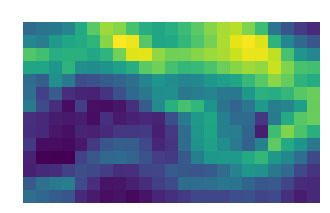

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(downscaled_image)
ax.axis('off')
plt.show()

In [22]:
bilinear = cv2.resize(downscaled_image, (200, 120), interpolation = cv2.INTER_LINEAR)
bicubic = cv2.resize(downscaled_image, (200, 120), interpolation = cv2.INTER_CUBIC)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


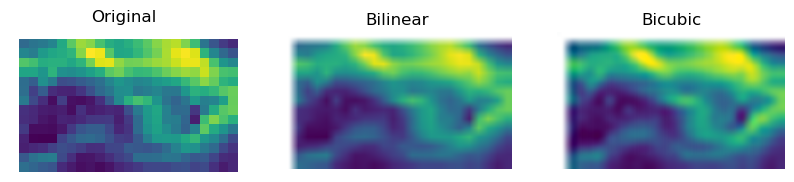

In [28]:
fig, axes = plt.subplots(1,3, figsize=(10,15))
axes[0].imshow(downscaled_image)
axes[0].axis('off')
axes[0].set_title("Original")
axes[1].imshow(bilinear)
axes[1].axis('off')
axes[1].set_title("Bilinear")
axes[2].imshow(bicubic)
axes[2].axis('off')
axes[2].set_title("Bicubic")
plt.show()